In [9]:
import os
import subprocess
import time
import pickle

import numpy as np

from matplotlib import pyplot as plt

import random
%matplotlib inline

In [10]:
import cv2

In [100]:
class Env:
    def __init__(self):
        self.restart_btn_img = cv2.imread('./restart_button.png', cv2.IMREAD_GRAYSCALE)
        self.action_space = range(20)
        self.dist_space = np.linspace(300, 1000, len(self.action_space))
    
    def __jump(self, distance):
        subprocess.call(".\\adb\\adb shell input swipe 500 500 500 500 %d" % distance)
        time.sleep(distance / 1000 + 2)
        
        
    def __capture_img(self, filename):
        subprocess.call('.\\adb\\adb shell /system/bin/screencap -p /sdcard/screenshot.png')
        time.sleep(0.1)
        subprocess.call('.\\adb\\adb pull /sdcard/screenshot.png %s' % filename)
        time.sleep(0.1)

        
    def __find_restart_btn(self, screen_shot_im):
        result = cv2.matchTemplate(screen_shot_im,
                                   self.restart_btn_img,
                                   cv2.TM_CCOEFF_NORMED)
        if result.max() > 0.8:
            y,x = np.unravel_index(result.argmax(),result.shape)
            y += self.restart_btn_img.shape[0] // 2
            x += self.restart_btn_img.shape[1] // 2
            return x, y
        else:
            return -1, -1
        
    def __to_state(self, screen_shot_im):
        return np.expand_dims(cv2.resize(screen_shot_im, (120, 200)) / 255.0,-1)
    
    
    def dist(self, action):
        d = action * 300 + 700
        if d < 300:
            d = 300
        elif d > 1000:
            d = 1000
            
        return d
        
        
    def reset(self):
        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            # Kill self
            self.__jump(1500)
            self.__capture_img('./tmp/screenshot.png')
            im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
            btn_x, btn_y = self.__find_restart_btn(im)
            
            assert btn_x != -1
                
        subprocess.call('.\\adb\\adb shell input tap %d %d' % (btn_x, btn_y))
        time.sleep(0.5)

        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)

        assert btn_x == -1
        
        return self.__to_state(im)
        
        
    def step(self, action):
        '''
        action: touch time(milliseconds)
        return: 
        '''
        time.sleep(0.5)
        
        dist = self.dist(action)
        self.__jump(dist)
        
        self.__capture_img('./tmp/screenshot.png')
        
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            state = self.__to_state(im)
            reward = 1
            done = False
            return state, reward, done
        else:
            state = None
            reward = -1
            done = True
            return state, reward, done
        

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 799822073069098840
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 118790553
locality {
  bus_id: 1
}
incarnation: 7333079319617550525
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:23:00.0, compute capability: 6.1"
]


In [62]:
from keras.layers import *
from keras.models import Model,load_model,Sequential
from keras.callbacks import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.applications.resnet50 import identity_block, conv_block

In [14]:
import tensorflow as tf

In [74]:
class ActorNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        K.set_session(sess)

        #Now create the model
        self.model , self.weights, self.state = self.create_actor_network()   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network() 
        self.action_gradient = tf.placeholder(tf.float32,[None, 1])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)
        self.sess.run(tf.initialize_all_variables())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(16, (8, 8), strides=(4,4), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)

        outputs = Dense(1, activation='linear')(x)
        model = Model(inputs, outputs)
        model.compile(loss='mean_squared_error', optimizer=Nadam(lr=self.LEARNING_RATE))

        return model, model.trainable_weights, inputs

In [90]:
class CriticNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        
        K.set_session(sess)

        #Now create the model
        self.model, self.state, self.action = self.create_critic_network()  
        self.target_model, self.target_state, self.target_action = self.create_critic_network()  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.initialize_all_variables())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        state_inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(state_inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(16, (8, 8), strides=(4,4), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x_s = Dense(256, activation='relu')(x)
        
        action_inputs = Input(shape=(1,))
        x_a = Dense(256, activation='relu')(action_inputs)
        
        x = Add()([x_s,x_a])
        x = Dense(256, activation='linear')(x)
        outputs = Dense(1, activation='linear')(x)
        
        model = Model([state_inputs, action_inputs], outputs)
        model.compile(loss='mean_squared_error', optimizer=Nadam(lr=self.LEARNING_RATE))
 
        return model, state_inputs, action_inputs 

In [109]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.memory = []
        
        self.GAMMA = 0.99
        self.TAU = 0.001     #Target Network HyperParameters
        self.LRA = 0.0001    #Learning rate for Actor
        self.LRC = 0.001     #Lerning rate for Critic

        self.episode_count = 2000
        self.max_steps = 100000
        self.reward = 0
        self.done = False
        self.step = 0
        self.epsilon = 1
        self.epsilon_decay = .97
        self.epsilon_min = 0
        self.indicator = 0

        #Tensorflow GPU optimization
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        K.set_session(self.sess)
        
        self.BATCH_SIZE = 32
        
        self.mem_len = 200

        self.actor = ActorNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRA)
        self.critic = CriticNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRC)
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def act(self, state):
        noise = random.gauss(mu=0,sigma=1) * self.epsilon
        
        act = self.actor.model.predict_on_batch(np.expand_dims(state,0))[0]
        
        print('act:',act[0],'noise:',noise,'sum:',act[0]+noise)
        
        return act[0] + noise
    
    
    def replay(self):
        mem = self.memory[-self.mem_len:]
        
        n_batch = min(self.BATCH_SIZE, len(mem))
        batches = np.random.choice(len(mem), n_batch)
        
        states = []
        actions = []
        rewards = []
        new_states = []
        dones = []
        
        for i,mem_idx in enumerate(batches):
            state, action, reward, next_state, done = mem[mem_idx]
            
            if done:
                next_state = np.zeros_like(state)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            new_states.append(next_state)
            dones.append(done)
        
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        new_states = np.array(new_states)

        target_q_values = self.critic.target_model.predict_on_batch(
            [new_states, self.actor.target_model.predict_on_batch(new_states)])
        
        y_t = []
        
        for k,d in enumerate(dones):
            if d:
                y_t.append(rewards[k])
            else:
                y_t.append(rewards[k] + self.GAMMA*target_q_values[k])
                
        y_t = np.array(y_t)
        
        loss = self.critic.model.train_on_batch([states,actions], y_t) 
        a_for_grad = self.actor.model.predict_on_batch(states)
        grads = self.critic.gradients(states, a_for_grad)
        self.actor.train(states, grads)
        self.actor.target_train()
        self.critic.target_train()
        
        return loss

In [110]:
episodes = 1000

# 为agent初始化gym环境参数
env = Env()
agent = Agent(env)

agent.actor.model.summary()
agent.critic.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_118 (InputLayer)       (None, 200, 120, 1)       0         
_________________________________________________________________
lambda_81 (Lambda)           (None, 120, 120, 1)       0         
_________________________________________________________________
average_pooling2d_81 (Averag (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 15, 15, 16)        1040      
_________________________________________________________________
activation_161 (Activation)  (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 8, 8, 32)          8224      
_________________________________________________________________
activation_162 (Activation)  (None, 8, 8, 32)          0         
__________

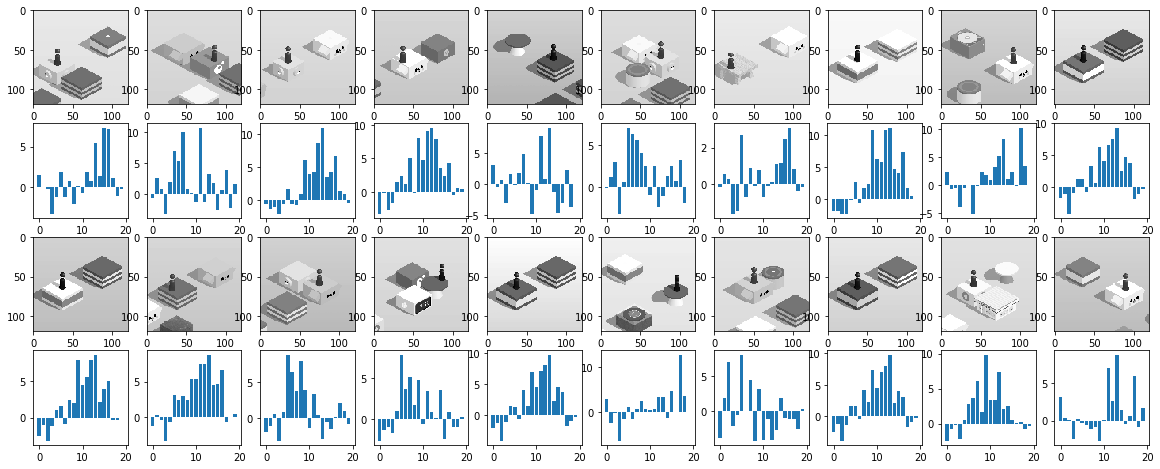

In [139]:
f, axes = plt.subplots(4,10,figsize=(20,8))

for i in range(4):
    for j in range(10):
        if i % 2 == 0:
            state = random.choice(agent.memory)[0]
            pic = state[50:170,:,0]
            axes[i][j].imshow(pic, cmap='gray')
        
            axes[i+1][j].bar(agent.env.action_space,agent.model.predict(np.expand_dims(state,0))[0])

In [111]:
scores = []

# 游戏的主循环
for e in range(episodes):

    # 在每次游戏开始时复位状态参数
    state = env.reset()

    # time_t 代表游戏的每一帧
    # time_t 越大，分数越高
    
    loss = 0
    for time_t in range(10000):
        
        # turn this on if you want to render
        # env.render()

        # 选择行为
        action = agent.act(state)

        # 在环境中施加行为推动游戏进行
        next_state, reward, done = env.step(action)
        
        print('jump dist:', env.dist(action))

        # 记忆先前的状态，行为，回报与下一个状态
        agent.remember(state, action, reward, next_state, done)

        # 使下一个状态成为下一帧的新状态
        state = copy.deepcopy(next_state)
        
        loss += agent.replay()

        # 如果游戏结束done被置为ture
        # 除非agent没有完成目标
        if done:
            # 打印分数并且跳出游戏循环
            print("episode: {}/{}, score: {}"
                  .format(e, episodes, time_t))
            scores.append(time_t)
            break
    
    loss /= (time_t+1)
    
    print('mem:', len(agent.memory), 'epsilon:', agent.epsilon, 'loss:', loss)
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

act: -0.0761222 noise: -0.2507238206304835 sum: -0.326846000258
jump dist: 601.946199923
act: -0.144215 noise: 0.8556605998508765 sum: 0.71144515016
jump dist: 913.433545048
act: -0.202374 noise: 0.8371287991626469 sum: 0.634754370652
jump dist: 890.426311196
act: -0.256858 noise: 0.10276147595692539 sum: -0.154096604669
jump dist: 653.771018599
episode: 0/1000, score: 3
mem: 4 epsilon: 1 loss: 0.531941380352
act: -0.299842 noise: -0.3650442945363278 sum: -0.664886711776
jump dist: 500.533986467
episode: 1/1000, score: 0
mem: 5 epsilon: 0.97 loss: 0.646307766438
act: -0.364665 noise: 0.30165128676331965 sum: -0.0630137744721
jump dist: 681.095867658
act: -0.409279 noise: -0.10132506305336109 sum: -0.510603575054
jump dist: 546.818927484
episode: 2/1000, score: 1
mem: 7 epsilon: 0.9409 loss: 1.04933524132
act: -0.482972 noise: 0.07817261740994376 sum: -0.404799199845
jump dist: 578.560240046
episode: 3/1000, score: 0
mem: 8 epsilon: 0.912673 loss: 0.740115404129
act: -0.517434 noise: -0

jump dist: 738.232264364
episode: 30/1000, score: 6
mem: 67 epsilon: 0.4010070685431576 loss: 0.582243936402
act: 0.0473107 noise: 0.27826004328876497 sum: 0.325570756967
jump dist: 797.67122709
act: 0.0444331 noise: 0.329058096105569 sum: 0.37349123537
jump dist: 812.047370611
act: 0.0498108 noise: 0.09695100848893685 sum: 0.146761827817
jump dist: 744.028548345
act: 0.045031 noise: -0.11437479408669916 sum: -0.0693437718062
jump dist: 679.196868458
act: 0.0851504 noise: -0.21339857917331181 sum: -0.128248218112
jump dist: 661.525534566
episode: 31/1000, score: 4
mem: 72 epsilon: 0.38897685648686287 loss: 0.457780897617
act: 0.0609633 noise: -0.24258775101808197 sum: -0.181624474244
jump dist: 645.512657727
act: 0.0603024 noise: -0.13794714680638315 sum: -0.0776447626087
jump dist: 676.706571217
episode: 32/1000, score: 1
mem: 74 epsilon: 0.377307550792257 loss: 0.414587110281
act: 0.071667 noise: 0.6426326780786318 sum: 0.714299686181
jump dist: 914.289905854
act: 0.0687418 noise: 0.

jump dist: 753.521539436
act: 0.134363 noise: 0.13225725832608576 sum: 0.266620596677
jump dist: 779.986179003
episode: 56/1000, score: 1
mem: 137 epsilon: 0.18164235290872485 loss: 0.187773615122
act: 0.138893 noise: 0.13663905161803813 sum: 0.275531791629
jump dist: 782.659537489
act: 0.142589 noise: 0.03287944667855522 sum: 0.175468389922
jump dist: 752.640516976
episode: 57/1000, score: 1
mem: 139 epsilon: 0.1761930823214631 loss: 0.143168907613
act: 0.146211 noise: 0.41888764332821354 sum: 0.56509858202
jump dist: 869.529574606
act: 0.133633 noise: -0.016174175052462804 sum: 0.117459110708
jump dist: 735.237733213
act: 0.124945 noise: 0.17127340568710384 sum: 0.296218152181
jump dist: 788.865445654
episode: 58/1000, score: 2
mem: 142 epsilon: 0.17090728985181922 loss: 0.285212427378
act: 0.145033 noise: 0.12496898350488507 sum: 0.270001866195
jump dist: 781.000559859
act: 0.139571 noise: -0.14976159215224785 sum: -0.0101903724696
jump dist: 696.942888259
act: 0.12397 noise: 0.0370

jump dist: 758.009103113
act: 0.253903 noise: -0.11649211404458171 sum: 0.137410708688
jump dist: 741.223212607
act: 0.25434 noise: -0.1559071244622438 sum: 0.0984325109099
jump dist: 729.529753273
episode: 74/1000, score: 6
mem: 215 epsilon: 0.10498042719488611 loss: 0.110547810793
act: 0.234214 noise: -0.17300050299731573 sum: 0.06121302802
jump dist: 718.363908406
act: 0.226294 noise: 0.13578195782601662 sum: 0.362075968704
jump dist: 808.622790611
act: 0.214603 noise: -0.04315150913395251 sum: 0.171451363595
jump dist: 751.435409079
episode: 75/1000, score: 2
mem: 218 epsilon: 0.10183101437903952 loss: 0.0891015107433
act: 0.216521 noise: 0.06824477251055443 sum: 0.284765678005
jump dist: 785.429703402
act: 0.21452 noise: 0.19435700112576323 sum: 0.408876948893
jump dist: 822.663084668
episode: 76/1000, score: 1
mem: 220 epsilon: 0.09877608394766833 loss: 0.10983774066
act: 0.226388 noise: -0.0633653885648283 sum: 0.163022544332
jump dist: 748.9067633
act: 0.235075 noise: -0.147526

act: 0.271616 noise: 0.04365298091955451 sum: 0.315269469615
jump dist: 794.580840884
act: 0.254619 noise: 0.0657534948602829 sum: 0.3203724674
jump dist: 796.11174022
act: 0.263035 noise: 0.000561230083506359 sum: 0.263595991036
jump dist: 779.078797311
act: 0.264512 noise: -4.756108882715175e-06 sum: 0.264507395371
jump dist: 779.352218611
act: 0.253306 noise: -0.007174215153756019 sum: 0.246132173701
jump dist: 773.83965211
episode: 96/1000, score: 4
mem: 291 epsilon: 0.053713875667199505 loss: 0.0520976301283
act: 0.267549 noise: -0.10252031564022698 sum: 0.165029050119
jump dist: 749.508715036
act: 0.27189 noise: -0.015420407999809828 sum: 0.25646999384
jump dist: 776.940998152
act: 0.259604 noise: -0.003350463884365108 sum: 0.256253155691
jump dist: 776.875946707
episode: 97/1000, score: 2
mem: 294 epsilon: 0.05210245939718352 loss: 0.0544992660483
act: 0.268692 noise: -0.09056444850773714 sum: 0.178127836315
jump dist: 753.438350894
act: 0.265978 noise: 0.03543565418620376 sum: 

act: 0.307231 noise: 0.043986218006091336 sum: 0.351217465431
jump dist: 805.365239629
act: 0.304446 noise: -0.015362593682896117 sum: 0.289082911459
jump dist: 786.724873438
episode: 120/1000, score: 1
mem: 359 epsilon: 0.02585878480181489 loss: 0.0195097979158
act: 0.291433 noise: 0.0010919477750900232 sum: 0.292525401335
jump dist: 787.7576204
act: 0.300498 noise: 0.023987236366638482 sum: 0.32448557292
jump dist: 797.345671876
episode: 121/1000, score: 1
mem: 361 epsilon: 0.025083021257760445 loss: 0.0469831665978
act: 0.292008 noise: 0.01648067514083545 sum: 0.308488747279
jump dist: 792.546624184
act: 0.285384 noise: 0.0144317663324262 sum: 0.299815646471
jump dist: 789.944693941
episode: 122/1000, score: 1
mem: 363 epsilon: 0.024330530620027633 loss: 0.0417675282806
act: 0.285146 noise: 0.02332559760246025 sum: 0.308472042638
jump dist: 792.541612792
act: 0.284615 noise: 0.006466004204255442 sum: 0.291081073832
jump dist: 787.32432215
episode: 123/1000, score: 1
mem: 365 epsilon

jump dist: 792.176717815
act: 0.294823 noise: -0.017855888216666466 sum: 0.276967043073
jump dist: 783.090112922
act: 0.296991 noise: 0.027502000019839535 sum: 0.324492990659
jump dist: 797.347897198
episode: 144/1000, score: 2
mem: 429 epsilon: 0.012448864341302825 loss: 0.00703288513857
act: 0.287205 noise: -0.010013237714975216 sum: 0.277192160368
jump dist: 783.15764811
act: 0.30239 noise: 0.01619326782119523 sum: 0.318583008765
jump dist: 795.57490263
act: 0.310933 noise: -0.007776296472896827 sum: 0.303157114648
jump dist: 790.947134395
episode: 145/1000, score: 2
mem: 432 epsilon: 0.01207539841106374 loss: 0.0379511611536
act: 0.290373 noise: -0.005263887658458474 sum: 0.285108633027
jump dist: 785.532589908
act: 0.281578 noise: -0.011977914664411398 sum: 0.269599821475
jump dist: 780.879946442
act: 0.288065 noise: 0.010351040410073608 sum: 0.298415818261
jump dist: 789.524745478
episode: 146/1000, score: 2
mem: 435 epsilon: 0.011713136458731828 loss: 0.0481099318713
act: 0.2871

act: 0.321631 noise: -0.00035100517670444095 sum: 0.321280366798
jump dist: 796.384110039
act: 0.310088 noise: 0.0011345637028275328 sum: 0.311222363729
jump dist: 793.366709119
episode: 165/1000, score: 1
mem: 502 epsilon: 0.006566533344523088 loss: 0.0225804429501
act: 0.326246 noise: 0.0077607870792035264 sum: 0.33400633342
jump dist: 800.201900026
act: 0.328956 noise: 0.0002827096466839026 sum: 0.329239134837
jump dist: 798.771740451
act: 0.331029 noise: -0.002699766573005009 sum: 0.32832917172
jump dist: 798.498751516
act: 0.345147 noise: 0.0011971005476881659 sum: 0.346344531444
jump dist: 803.903359433
act: 0.349351 noise: -0.0026471983481086547 sum: 0.346703969331
jump dist: 804.011190799
act: 0.34643 noise: -0.00821848268131048 sum: 0.338211312345
jump dist: 801.463393704
act: 0.345392 noise: 0.002435696671916784 sum: 0.347827506612
jump dist: 804.348251984
act: 0.352825 noise: -0.006511664313489711 sum: 0.346313768702
jump dist: 803.894130611
act: 0.328681 noise: 0.0024259890

KeyboardInterrupt: 

In [47]:
%debug

> <ipython-input-11-31b434801c34>(8)__jump()
      6 
      7     def __jump(self, distance):
----> 8         subprocess.call(".\\adb\\adb shell input swipe 500 500 500 500 %d" % distance)
      9         time.sleep(distance / 1000 + 2)
     10 

ipdb> action
416.63022541769755
ipdb> dist
*** NameError: name 'dist' is not defined
ipdb> distance
ipdb> up
> <ipython-input-11-31b434801c34>(75)step()
     73 
     74         dist = self.dist(action)
---> 75         self.__jump(dist)
     76 
     77         self.__capture_img('./tmp/screenshot.png')

ipdb> action
416.63022541769755
ipdb> self.dist
<bound method Env.dist of <__main__.Env object at 0x0000018C4FEBAD68>>
ipdb> self.dist(action)
ipdb> dist
ipdb> q


In [70]:
agent.epsilon = 0.01

<Container object of 20 artists>

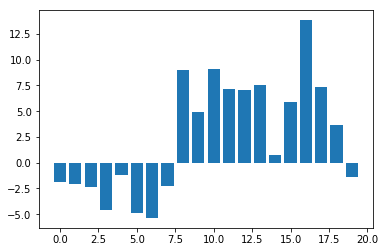

In [117]:
plt.bar(agent.env.action_space,agent.model.predict(np.expand_dims(agent.memory[][0],0))[0])

In [91]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(*args, **kwargs)
    Make a bar plot.
    
    Call signatures::
    
       bar(x, height, *, align='center', **kwargs)
       bar(x, height, width, *, align='center', **kwargs)
       bar(x, height, width, bottom, *, align='center', **kwargs)
    
    Make a bar plot with rectangles bounded by
    
    .. math::
    
       (x - width/2, x + width/2, bottom, bottom + height)
    
    (left, right, bottom and top edges) by default.  *x*,
    *height*, *width*, and *bottom* can be either scalars or
    sequences.
    
    The *align* and *orientation* kwargs control the interpretation of *x*
    and *bottom*
    
    The *align* keyword-only argument controls if *x* is interpreted
    as the center or the left edge of the rectangle.
    
    Parameters
    ----------
    x : sequence of scalars
        the x coordinates of the bars.
    
        *align* controls if *x* is the bar center (default) or
        left edge.
    
    heig

In [138]:
agent.model.save_weights('./tmp/weights.w')
pickle.dump(agent.memory, open('./tmp/memory.m','wb'))

In [68]:
min_loss = 1e10
min_pos = 0

for i in range(1000):
    loss = 0
    for i in range(50):
        l = agent.replay(32)
        loss += l
    print(loss / 50)
    
    if loss < min_loss:
        min_pos = i
        min_loss = loss
    
    if i - min_pos > 100:
        break

i

128.82689827
94.7225925446
37.4278962708
31.1282489967
15.9667807198
16.0796065235
14.0383515739
12.0921261883
11.2964262009
8.64634869099
7.35213395119
7.32252527714
6.3635424757
4.71984107256
4.57263987064
3.77086829185
4.77240906715
3.48491025209
9.52575344563
5.55766092539
4.55353834867
3.18393145323
2.79013663769
2.49263638139
3.06989862561
4.35556167364
2.88895393372
2.96023203969
3.11350908041
4.47541817427
3.99412070513


KeyboardInterrupt: 

In [58]:
i, min_pos

(228, 227)

In [178]:
agent.epsilon

0.20554993075174754